# Import Tensorflow & Libraries / Set Up Environment

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.layers import Dense, Activation, InputLayer, Flatten, Conv2D, MaxPool2D, BatchNormalization # Convolutional & Other Layers
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation # Data Augmentation
from tensorflow.keras.optimizers import Adam # Optimize Learning Rate
from tensorflow.keras.losses import CategoricalCrossentropy # Optimize Loss for Classification
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.models import Sequential # Sequential NN Model

# Train CNN Model using Tensorflow (Ignore Warnings): When we use GPU for tensorflow model training, there will be some loss of precision in the program which will yield higher training error. This is expected, so we can ignore tf warnings.
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

# Data Processing
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Additional imports
import os, warnings
warnings.filterwarnings('ignore')
import random

SEED = 12345
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Get image frame for accuratge data representation
sample_img = Image.open("/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/Val/Pituitary/images/Tr-pi_0470.jpg")
img_w, img_h = sample_img.size

# Retrieve classification data
def get_data(path:str):
    return image_dataset_from_directory(
        f'/kaggle/input/mri-for-brain-tumor-with-bounding-boxes/{path}',
        labels='inferred',
        label_mode='categorical',
        image_size=[img_w,img_h], # Image standard shape
        interpolation='nearest', # When resizing, fill in using the nearest values
        batch_size=32, # Collection of trained images at once
        shuffle=True, # Shuffle upon collecting a batch
    )

# converting data type to float32 and returning both image and label to protect dimentionality
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

# Create Training and Validation Data

In [4]:
train_ = get_data(path='Train')
val_ = get_data(path='Val')

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (
    train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

val = (
    val_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 4737 files belonging to 4 classes.
Found 512 files belonging to 4 classes.


# Optional: Custom Kernels
When applying a convolution network, it is possible to apply your own kernels to extract certain specific features from the input image. I didn't use anything as such in my model training, though I've still included a playground below with 3x3 kernels where you can see two examples of custom kernels and how they affect the image step-by-step.

If you know what features you need to extract from image, then custom kernels come in pretty handy. Still without manually injecting kernels, you can let the model decide for itself a good kernel.

In [5]:
pg_img = np.array(next(iter(val.unbatch().map(lambda x,y: x).batch(1))))[0]
# Greyscale image before passing to kernel
r, g, b = pg_img[:,:,0], pg_img[:,:,1], pg_img[:,:,2]
greyscaled = (r + g + b) / 3
# Sharpening Kernel (3x3)
kernel_1 = tf.constant([ [1,2,1], [0,0,0], [-1,-2,-1] ],)
# Edge Detection Kernel (3x3)
kernel_2 = tf.constant([ [-1,-2,-1], [0,0,0], [1,2,1] ],)

In [6]:
conv_net_1 = Sequential([
        InputLayer(shape=[*greyscaled.shape,1]),
        BatchNormalization(center=True,scale=False),
        Conv2D(filters=1,kernel_size=kernel_1.shape,strides=1,padding='valid',use_bias=False),
        Activation('relu'),
        MaxPool2D(pool_size=1,strides=1,padding='same')
        ,
        Conv2D(filters=1,kernel_size=kernel_2.shape,strides=1,padding='valid', use_bias=False),
        Activation('relu'),
        MaxPool2D(pool_size=2,strides=1,padding='same')
    ])

# Extract layers from model and apply custom kernel
l_norm, l_filter, l_detect, l_condense, l_filter_2, l_detect_2, l_condense_2 = conv_net_1.layers
# 1st Convolution Kernel (Weights)
kernel_1 = tf.reshape(kernel_1, [*kernel_1.shape, 1, 1])
l_filter.set_weights([kernel_1])
# 2nd Convolution Kernel (Weights)
kernel_2 = tf.reshape(kernel_2, [*kernel_2.shape, 1, 1])
l_filter_2.set_weights([kernel_2])
# Rescale image for model compatability
greyscaled = tf.expand_dims(greyscaled, axis=0)
greyscaled = tf.image.convert_image_dtype(greyscaled, dtype=tf.float32)
greyscaled = tf.reshape(greyscaled, [*greyscaled.shape, 1])
# Extract features layer-by-layer
normed_1 = l_norm(greyscaled)
filtered_1 = l_filter(normed_1)
detect_1 = l_detect(filtered_1)
condensed_1 = l_condense(detect_1)
filtered_2 = l_filter_2(condensed_1)
detect_2 = l_detect_2(filtered_2)
condensed_2 = l_condense_2(detect_2)
# Reshape original image so that all element of the list are of uniform shape
pg_img = tf.expand_dims(pg_img, axis=0)
pg_img = tf.image.convert_image_dtype(pg_img, dtype=tf.float32)
pg_img = tf.reshape(pg_img, [*pg_img.shape, 1])
# Get all stages of image in one list
img_states = [pg_img,greyscaled,normed_1,filtered_1,detect_1,condensed_1,filtered_2,detect_2,condensed_2] # Combine all steps in one list

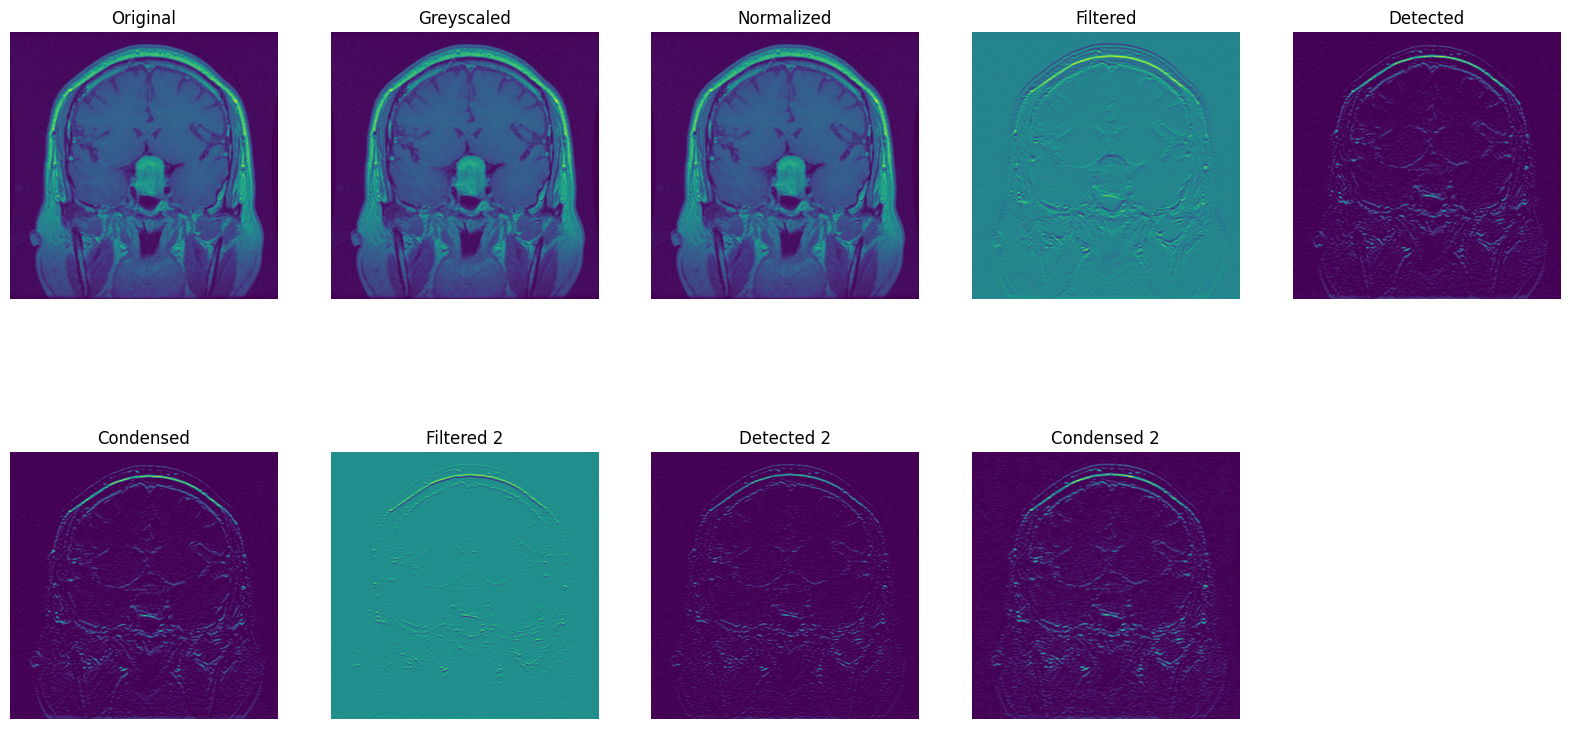

In [7]:
# Play around with kernels to find the one(s) that highlights the correct features from image
ops = ["Original","Greyscaled","Normalized","Filtered","Detected","Condensed","Filtered 2", "Detected 2","Condensed 2"]
plt.figure(figsize=(20,10))
for i, stage in enumerate(img_states):
    display = (stage[0].numpy())[:,:,0] # Reshape current image for display
    plt.subplot(2, 5, i+1)
    plt.imshow(tf.squeeze(display))
    plt.title(ops[i])
    plt.axis('off')
plt.show()

# Optional: Augmentation Playground
### What Is Data Augmentation?'
Data Augmentation is the process of altering the current dataset you have access to generate new cases of data. This method is particularly useful if you need variation in your dataset and/or you don't have access to more data; when you have to make the best out of your given data.

For example, you can skew an image and alter its shape, colors, contrast, and apply many other things. Below, I've included two examples; one for contrast and one for flipping image. Play around and see the results by running the code block below.

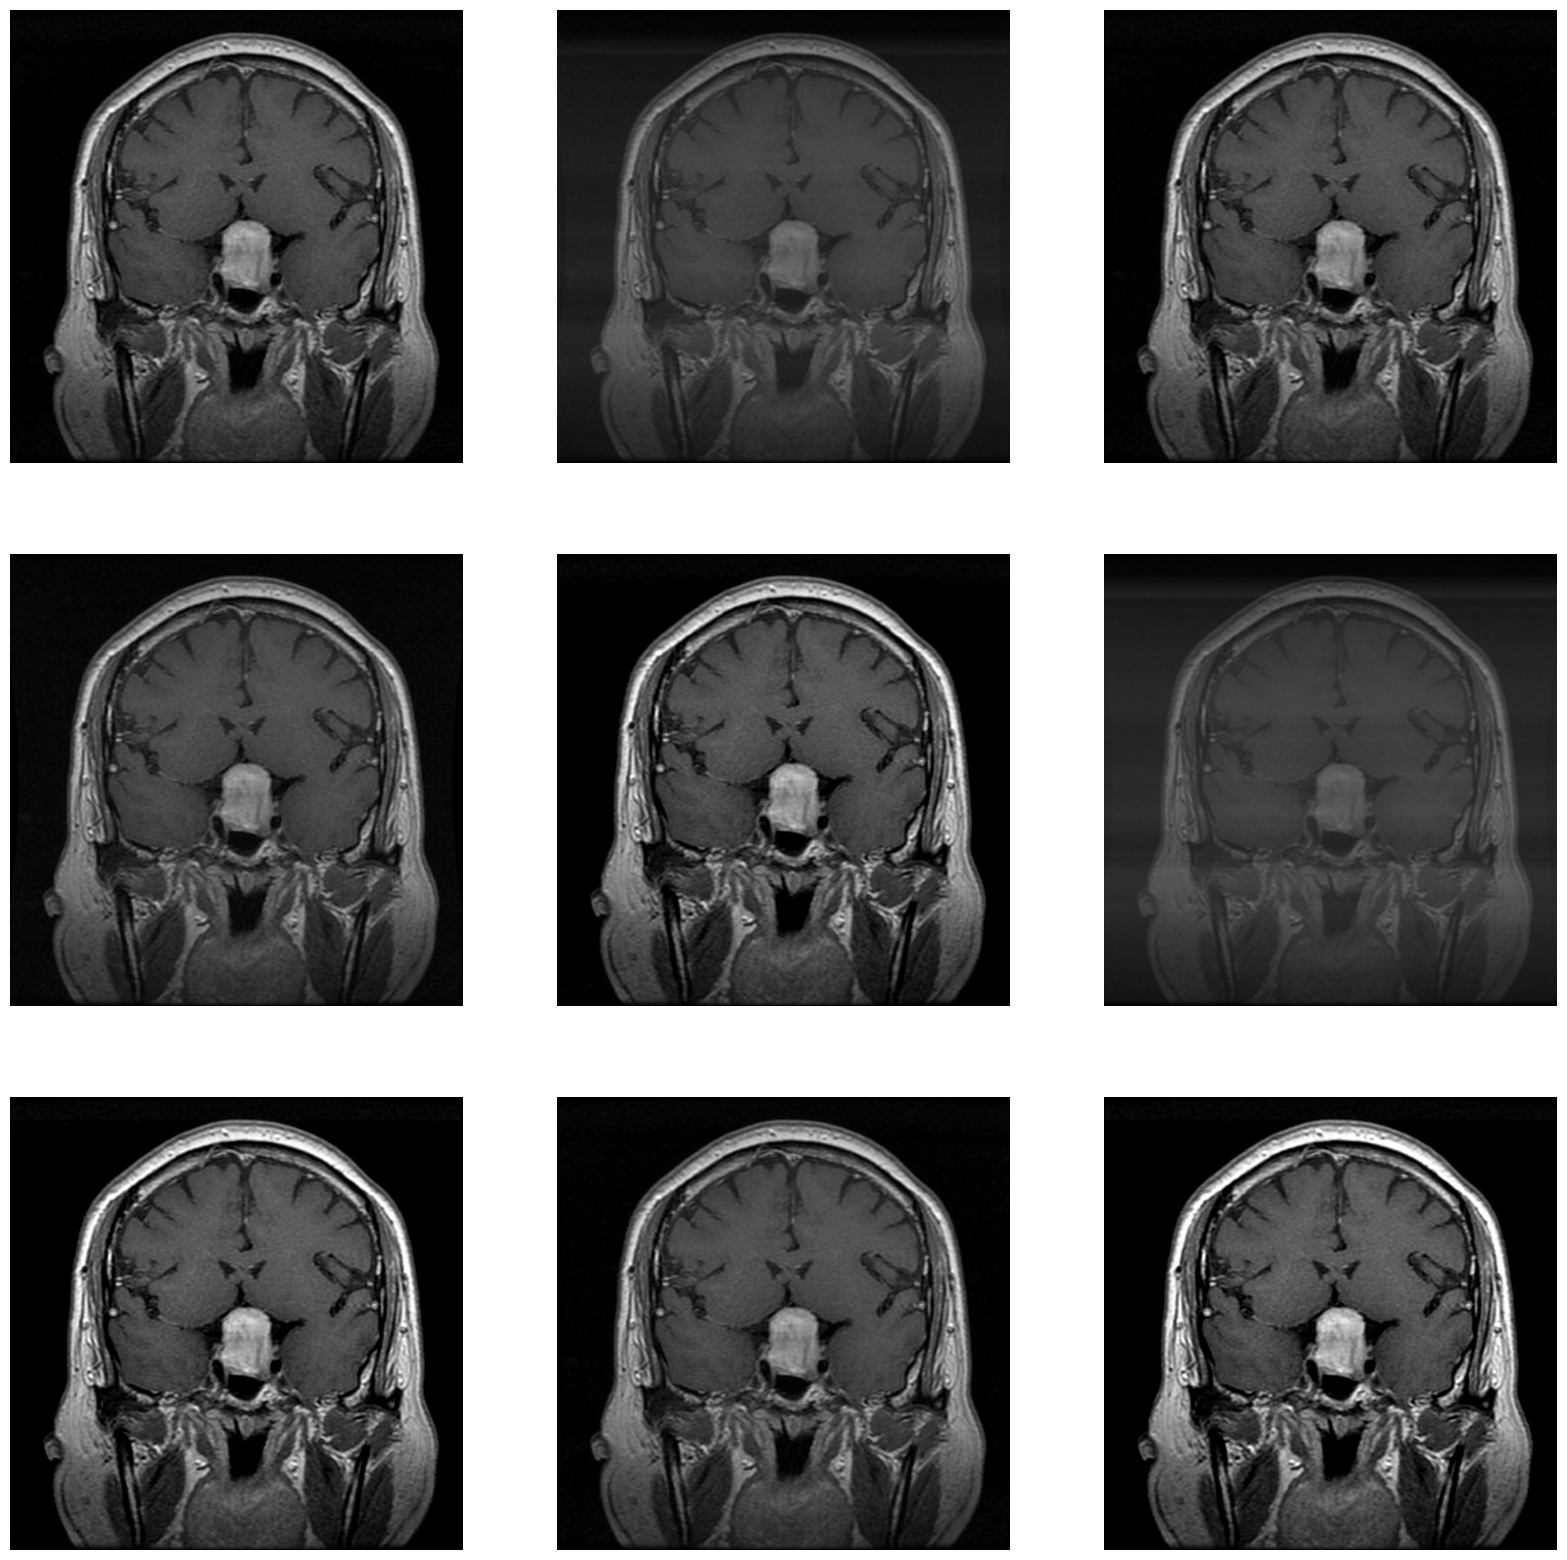

In [8]:
# Play around with different augmentations and see their effects on an example image

augmentations = Sequential([
    RandomContrast(factor=0.8),
    RandomFlip(mode='horizontal')
])

plt.figure(figsize=(20,20))
for i in range(9):
    image = augmentations(pg_img, training=True)
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

#  Model Building & Training
`build_model`: Creates the tensor Sequential model and adds the necessary layers for image convolution and the head segment (interpreter).
### Convolutional Segment
For convolution, I used two convolutional blocks. 1st Convolutional Block extracts 3 features, which is intended to find general distinguishments between images. The 2nd layer extracts 9 features for better evaluation and to ensure the model is complex enough to draw accurate analysis. Values beyond 9 can slightly increase accuracy. However, they compromise the computation time for when we're optimizing unit numbers, lambda_ (for L2 regularization), and post-train pruning (you'll see them later in this notebook).

The features we're trying to extract from an MRI are localized, which means our kernel and pooling sizes have to protect the local information. With a kernel size too big, local information would've been lost, so the kernel sizes in both convolution layers are set to (1,1) by default.
### Head Segment
After trial and error, I've decided to use 3 hidden layers. Any additional hidden layer would increase computing time without providing any more notable information (increase in model accuracy). The number of units for hidden layers are 256, 256, and 128 respectively. Through trial and error, these units numbers have been determined as strong default picks.

ReLU is known to show consistent and accurate performance for hidden layers across many neural network projects. So I also used ReLU activation as the activation function for hidden layers.

As for the output model, since the project addresses a classification problem and there's 4 categories to choose from, that leaves us with only one choice of layer; Softmax for activation and 4 units.

In [9]:
def build_model(filter_1 = 3,
                filter_2 = 9,
                kernel_shape_1 = (1,1),
                kernel_shape_2 = (1,1),
                dilation_rate_1 = (1,1), # Skips between two kernels on the image (h,v)
                dilation_rate_2 = (1,1),
                conv_padding = 'valid',
                hidden_units = [256,256,128],
                input_shape = [img_w,img_h,3],
                l2_lambda = 0
               ):
    model = Sequential()
    model.add(InputLayer(shape=[img_w,img_h,3]))
    # Convolutional Block One
    model.add(BatchNormalization())
    model.add(Conv2D(filters=filter_1,kernel_size=kernel_shape_1,dilation_rate=dilation_rate_1,padding=conv_padding,activation='relu'))
    model.add(MaxPool2D())
    # Convolutional Block Two
    model.add(Conv2D(filters=filter_2,kernel_size=kernel_shape_2,dilation_rate=dilation_rate_2,padding=conv_padding,activation='relu'))
    model.add(MaxPool2D())
    model.add(Flatten())
    model.add(Dense(units=hidden_units[0],activation='relu'))
    model.add(Dense(units=hidden_units[1],activation='relu'))
    model.add(Dense(units=hidden_units[2],activation='relu'))
    model.add(Dense(units=4,activation='softmax',kernel_regularizer=L2(l2_lambda)))
    return model

def train_model(model, n_epoch=5, verbose=1, batch_size=32,validation_split=0):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    callback = model.fit(
        train,
        validation_data=val,
        batch_size=batch_size,
        validation_split=validation_split,
        epochs=n_epoch,
        verbose=verbose
    )
    return callback
    
    

Let's build the model with default parameters to see how it performs:

In [10]:
model = build_model()
history = train_model(model,n_epoch=15)

Epoch 1/15
  3/149 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.3142 - loss: 3.6189

I0000 00:00:1724675452.621809     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 188ms/step - accuracy: 0.5014 - loss: 3.8832 - val_accuracy: 0.1953 - val_loss: 3.5846
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7099 - loss: 0.8024 - val_accuracy: 0.3184 - val_loss: 2.1358
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.7991 - loss: 0.4900 - val_accuracy: 0.7441 - val_loss: 0.6082
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8544 - loss: 0.3444 - val_accuracy: 0.8242 - val_loss: 0.4392
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8982 - loss: 0.2667 - val_accuracy: 0.7715 - val_loss: 0.7846
Epoch 6/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8764 - loss: 0.3004 - val_accuracy: 0.7715 - val_loss: 0.6948
Epoch 7/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9481 - loss: 0.1444 - val_accuracy: 0.7695 - val_loss: 0.7299
Epoch 8/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.9622 - loss: 0.1111 - val_accuracy: 

And here's the validation accuracy:

In [ ]:
model.evaluate(val)

# Optimize Hidden Layer Units
In order to build a reliable model, first we need to determine a network structure within a good range of accuracy. Regularization and Pruning (which comes later below) already eliminate the redundant neurons from the model structure. However it's still a good start to find an accurate network structure. This step takes up to an hour, so if it feels overly long, the default network structure is also a strong pick. So work this code if you want to, but even without it you should be fine.

The result from this code `best_units` is not included in the final model training (which you'll see after regularization).

In [ ]:
def optimal_units(min_:int,max_:int,step:int,default:list[int,int,int]=[256,256,128]):
    
    units = list(range(min_,max_,step))
    optimals = list(default)
    
    for i in range(0,len(optimals)):
        best_n_units = -1
        best_loss = 0
        
        for n, unit in enumerate(units):
            hidden_units = list(optimals) # Make new copy of current structure
            hidden_units[i] = unit # Assign current unit to optimizing layer index
            model = build_model(hidden_units=hidden_units) # Build model with current neuron structure
            print(f"Building neuron structure {hidden_units} ({(i+1)*(n+1)} out of {len(optimals)*len(units)})\n")
            history = train_model(model,n_epoch=10,verbose=0) # Train model with 5 epochs
            val_loss = history.history["val_loss"][-1] # Get the latest epoch validation loss
            if val_loss < best_loss or best_n_units == -1:
                best_n_units = unit
                best_loss = val_loss
        optimals[i] = best_n_units
        
    return optimals

In [ ]:
# What is the best value for step that checks performance in regular intervals but doesn't consume much time?
best_units = optimal_units(min_=32,max_=512,step=20)

In [ ]:
test_model = build_model(hidden_units=best_units)
history = train_model(test_model,n_epoch=15)

# L2 (Lasso) Regularization and Chart Results

### What Is Regularization?
In a neural network of moderate/high complexity and demanding task, the model becomes prone to overfitting the given training set. Regularization can help us prevent this by driving overfitting weights to near zero, so that the model prediction fits the trend suggested by the data instead of fitting every single training example.

The tensorflow library offers an easy solution to apply arguably the most popular regularization technique; Lasso Regularization. **CONTINUE HERE**

Below is an optimization function that selects the best lambda value given a list of options. By optimizing the lambda value, the model can find the right balance between **bias** and **variance** (**underfit** and **overfit**).

In [12]:
def best_lambda(reg_terms, hidden_units=[256,256,128], n_epoch=10, chart=False):
    histories = []
    stats = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'lambda': list(reg_terms)
    }
    
    best_lambda = -1
    best_loss = 0
    
    for term in reg_terms:
        print(f"Building for lambda: {term} (one step may take up to 3 minutes)")
        model = build_model(hidden_units=hidden_units,l2_lambda=term)
        history = train_model(model,n_epoch=n_epoch,verbose=0)
        val_loss = history.history["val_loss"][-1]
        # Append training results for charting
        histories.append(history.history)
        stats["train_loss"].append(history.history["loss"][-1])
        stats["val_loss"].append(val_loss)
        stats["train_acc"].append(history.history["accuracy"][-1])
        stats["val_acc"].append(history.history["val_accuracy"][-1])
        if val_loss < best_loss or best_lambda == -1:
            best_lambda = term
            best_loss = val_loss
            
    # If chart == False, return result without charting the list
    if not chart:
        return best_lambda, stats
    
    # Chart the results
    figure, axis = plt.subplots(len(reg_terms), 2,figsize=(20,20))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    for i,hst in enumerate(histories):
        val_loss = hst["val_loss"]
        train_loss = hst["loss"]
        val_acc = hst["val_accuracy"]
        train_acc = hst["accuracy"]
        epochs = list(range(1,len(hst["loss"])+1)) # All have the same length
        # Plot loss
        axis[i,0].plot(epochs,val_loss,'r',epochs,train_loss,'b')
        axis[i,0].set_title(f"Lambda: {lambdas[i]} (Loss)")
        axis[i,0].set_xlabel("Epochs")
        axis[i,0].set_ylabel("Loss")
        axis[i,0].text(0.8, 0.9, 'Validation', horizontalalignment='center', verticalalignment='center', transform=axis[i,0].transAxes, color='r')
        axis[i,0].text(0.8, 0.8, 'Train', horizontalalignment='center', verticalalignment='center', transform=axis[i,0].transAxes, color='b')
        # Plot accuracy
        axis[i,1].plot(epochs,val_acc,'r',epochs,train_acc,'b')
        axis[i,1].set_title(f"Lambda: {lambdas[i]} (Acc)")
        axis[i,1].set_xlabel("Epochs")
        axis[i,1].set_ylabel("Accuracy")
        axis[i,1].text(0.8, 0.2, 'Validation', horizontalalignment='center', verticalalignment='center', transform=axis[i,1].transAxes, color='r')
        axis[i,1].text(0.8, 0.1, 'Train', horizontalalignment='center', verticalalignment='center', transform=axis[i,1].transAxes, color='b')
    plt.show()
    # Return best lambda
    return best_lambda, stats

def plot_lambda_result(stats,lambda_):
    figure, (ax1,ax2) = plt.subplots(2,1,figsize=(15,15))
    # Plot model loss
    ax1.plot(stats["lambda"],stats["train_loss"],'b',stats["lambda"],stats["val_loss"],'r')
    ax1.set_title("Loss (by Lambda)")
    ax1.set_xscale("log")
    ax1.set_xlabel("Lambda")
    ax1.set_ylabel("Loss")
    ax1.text(0.8, 0.9, 'Validation', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, color='r')
    ax1.text(0.8, 0.8, 'Train', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, color='b')
    ax1.axvline(lambda_)
    # Plot model accuracy
    ax2.plot(stats["lambda"],stats["train_acc"],'b',stats["lambda"],stats["val_acc"],'r')
    ax2.set_title("Accuracy (by Lambda)")
    ax2.set_xscale("log")
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Accuracy")
    ax2.text(0.8, 0.2, 'Validation', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, color='r')
    ax2.text(0.8, 0.1, 'Train', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, color='b')
    ax2.axvline(lambda_)
    # Show final result
    plt.show()

Here's the performance results of some lambda values I have picked for model optimization. To see different results, you can increase the training iterations through `n_epoch` parameter, or change the sample values in the `lambdas` list of lambda values.

Building for lambda: 0.0001 (one step may take up to 3 minutes)
Building for lambda: 0.0005 (one step may take up to 3 minutes)
Building for lambda: 0.001 (one step may take up to 3 minutes)
Building for lambda: 0.005 (one step may take up to 3 minutes)
Building for lambda: 0.01 (one step may take up to 3 minutes)
Building for lambda: 0.05 (one step may take up to 3 minutes)


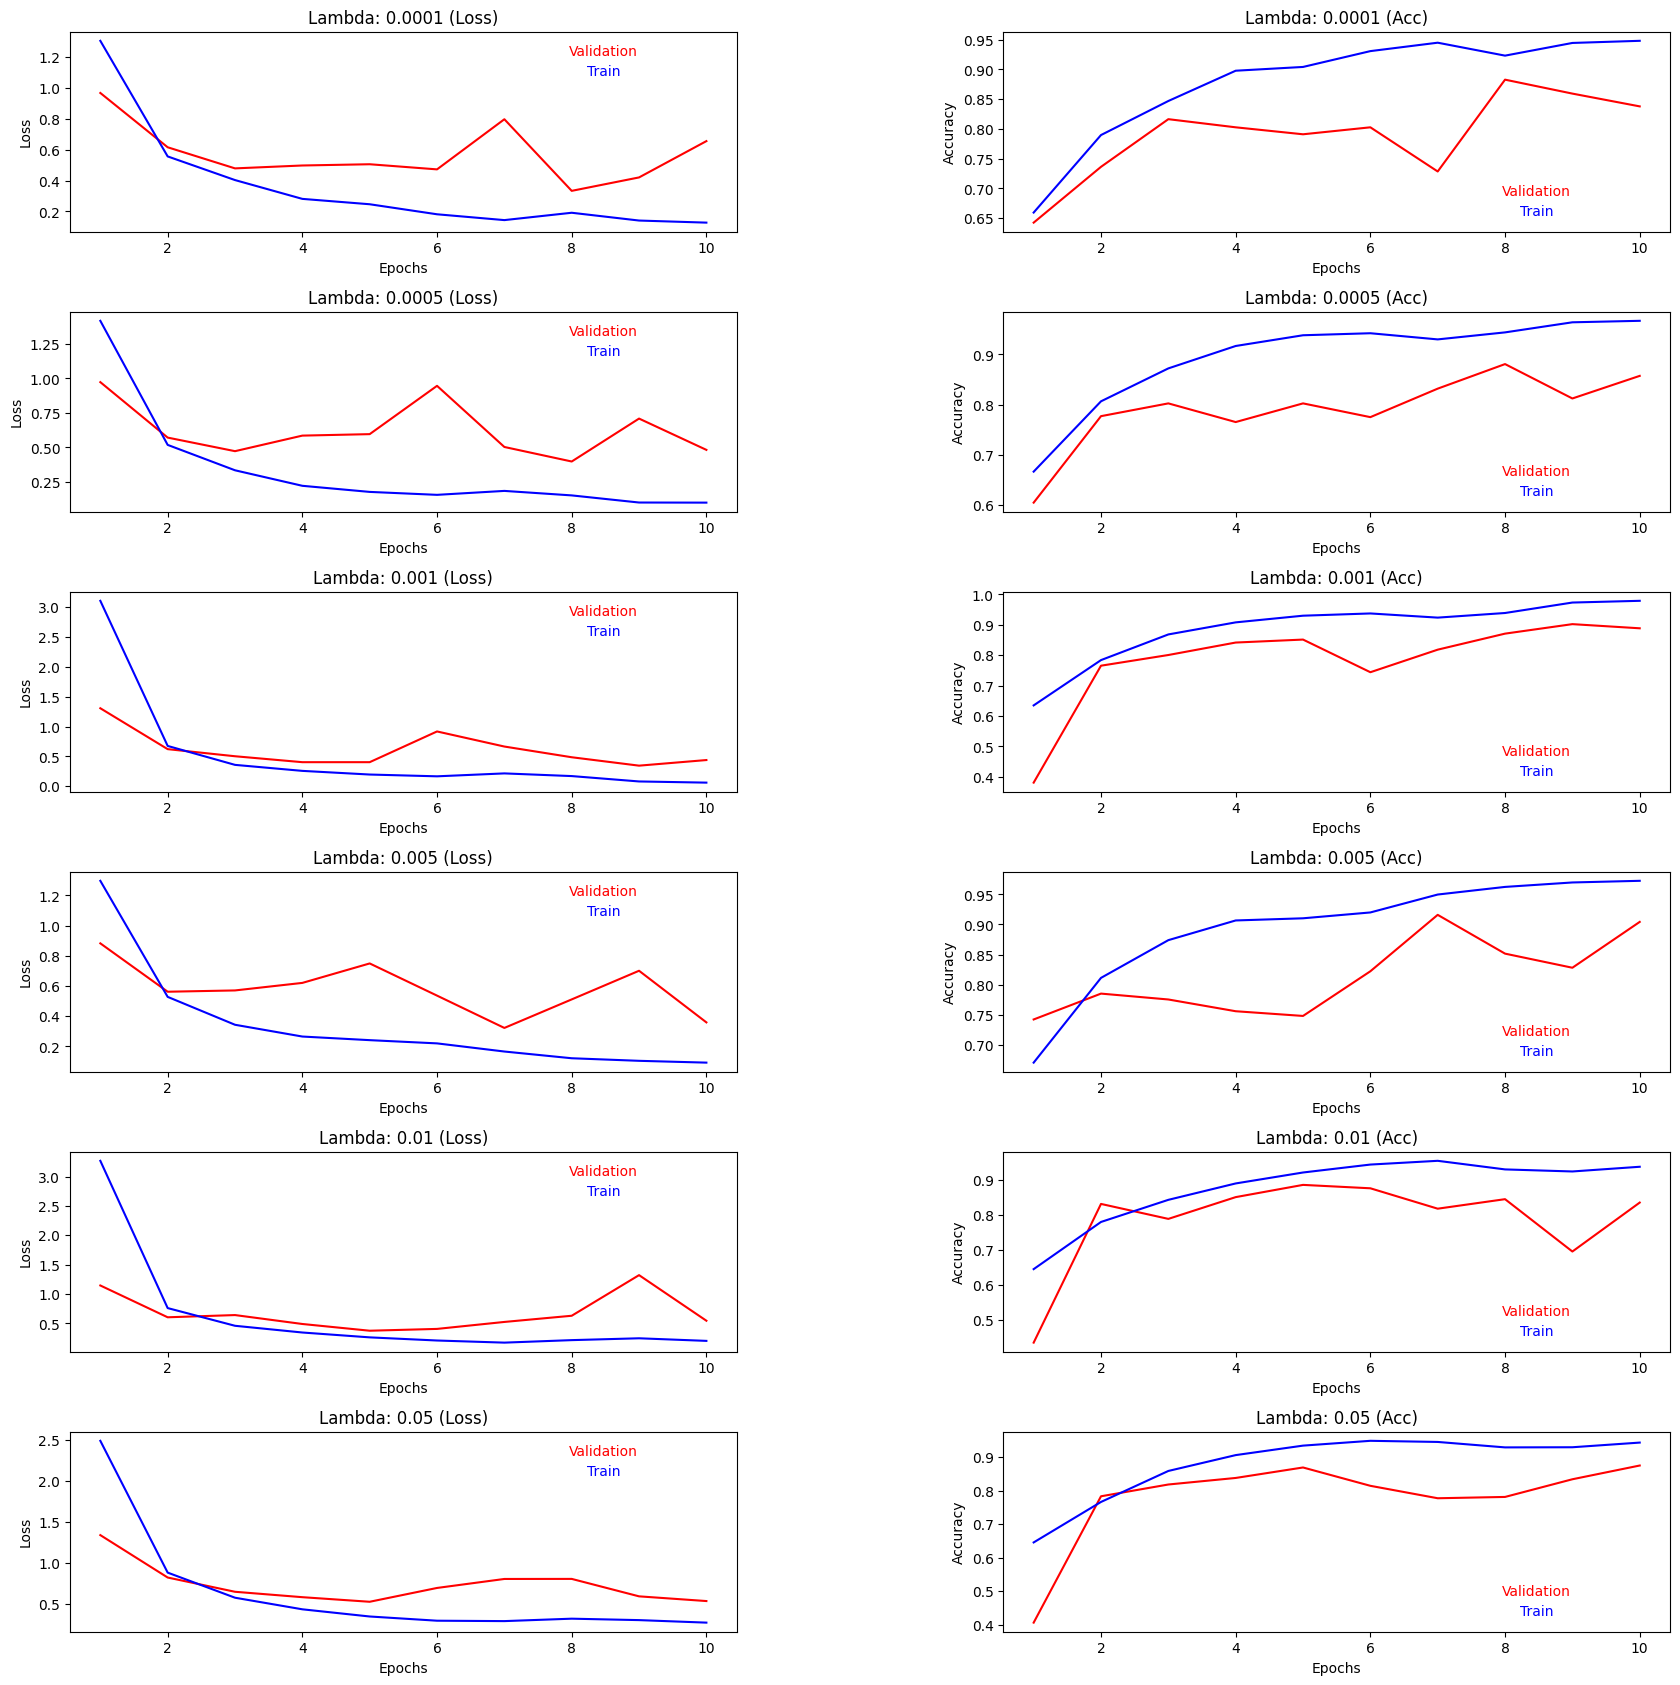

In [13]:
lambdas = [0.0001,0.0005,0.001,0.005,0.01,0.05]
lambda_, stats = best_lambda(lambdas,n_epoch=10,chart=True)

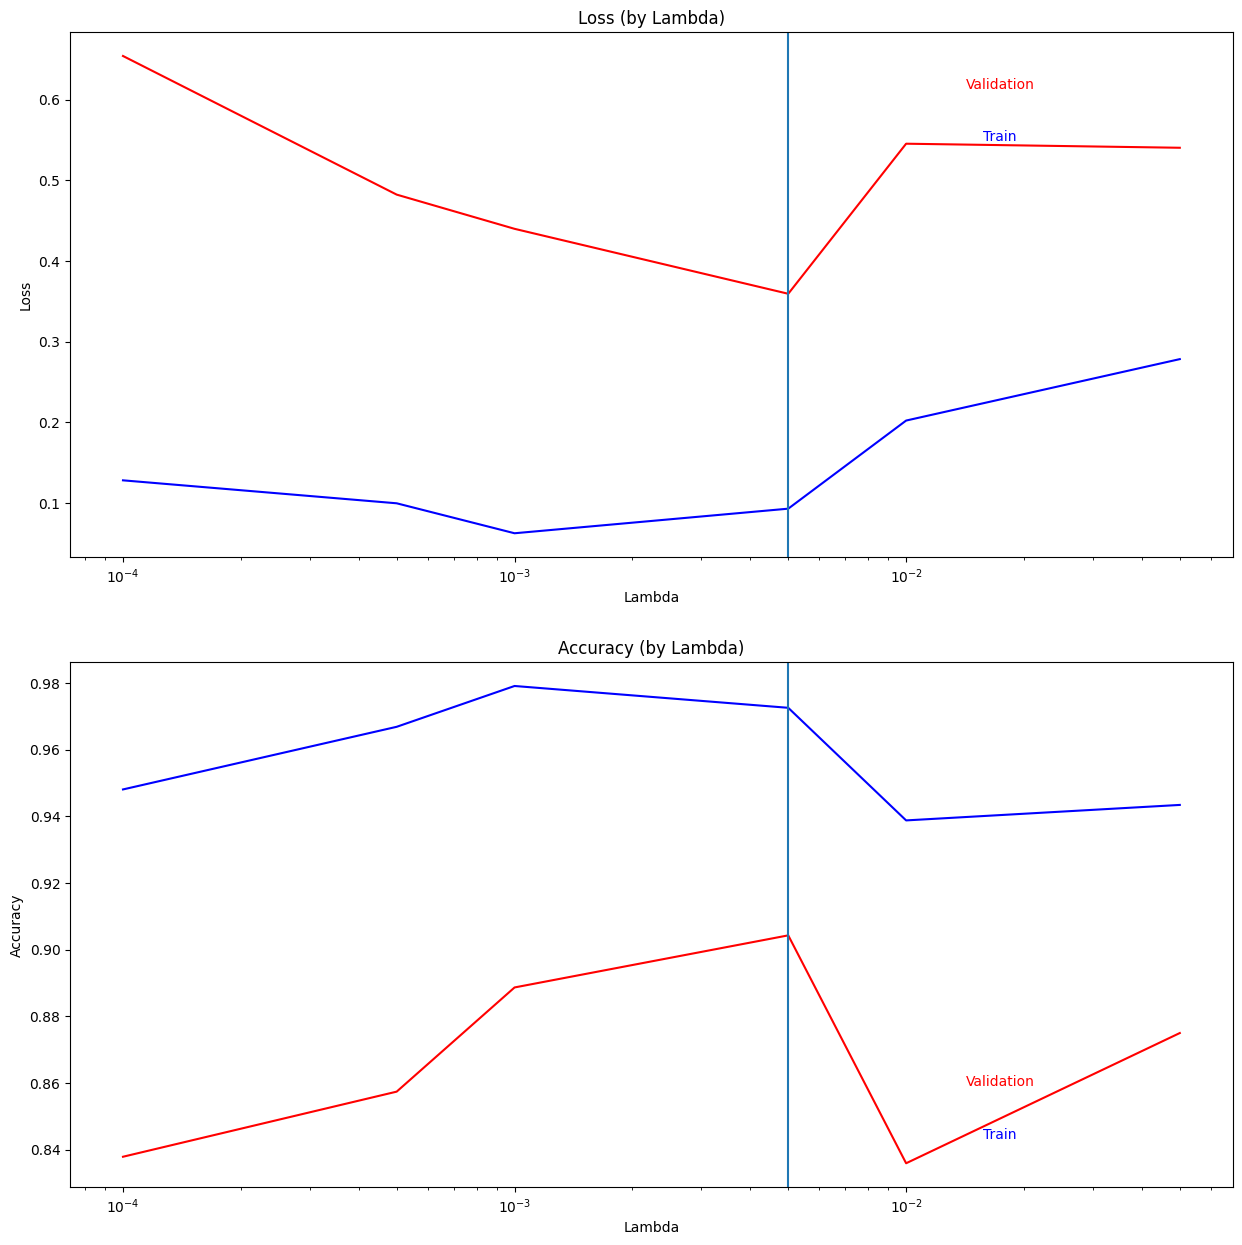

In [14]:
plot_lambda_result(stats,lambda_)

# Train Final Model
Train final model after finding `lambda_`:

In [15]:
final_model = build_model(l2_lambda=lambda_)
hist = train_model(final_model,n_epoch=20)

Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.5128 - loss: 5.8951 - val_accuracy: 0.5879 - val_loss: 0.9417
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7183 - loss: 0.9330 - val_accuracy: 0.7676 - val_loss: 0.5919
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7970 - loss: 0.5880 - val_accuracy: 0.8301 - val_loss: 0.4811
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.8734 - loss: 0.3359 - val_accuracy: 0.7246 - val_loss: 0.9907
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.8915 - loss: 0.3059 - val_accuracy: 0.7891 - val_loss: 0.7302
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9364 - loss: 0.2075 - val_accuracy: 0.7715 - val_loss: 0.8931
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9214 - loss: 0.2358 - val_accuracy: 0.8730 - val_loss: 0.4756
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9671 - loss: 0.1156 - val_acc

In [16]:
final_model.evaluate(val)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9223 - loss: 0.5852


[0.4656290113925934, 0.931640625]

# Model Post-train Pruning

### What is Post-train Pruning?
Post train pruning is the process of removing unnecessary neurons from network by nullifying their weight. As we train our model further, it becomes liable to overfit the training data and miss the overall trend suggested by it. We have already accounted for this by applying Lasso (L2) Regularization. However, as a final touch to the model, it is recommended to prune network after training so to maximize the validation accuracy (and/or minimize validation loss).

All neurons optimize themselves using the regression expression of `w · x + b`. When we assign `w = 0`, the effect of `x` on the prediction output nullifies. This is the underlying idea behind pruning.

Below are two ways this can be done. First let's import the `copy` library so that we can create copies of the `keras.models.Sequential` model.

In [17]:
from copy import copy # Copy tensorflow models to avoid overwriting data

### Pruning by Magnitude
In this algorithm, a copy of the model is created for pruning since we don't want to overwrite the trained model in case the resulting accuracy is worse. After, the layers are extracted from the hidden layers of the model, and any weight value we have determined to be insignificant is set to 0. The threshold value is determined by the `smaller_than` parameter, which is set to 10^-3 by default.

Since we don't know what threshold value is improving the model from the beginning, I also wrote an optimizing function `optimize_prune_mag` that lets you determine a number of examples you want to test out within the `min_` and `max_` parameters. The best performing threshold example is returned from the optimizing function.

However, as you'll see right after this block of code, I preferred to use a different approach of pruning since I believe it yields better results.

In [18]:
# REMEMBER TO MAKE A COPY OF THE ORIGINAL MODEL SO THAT YOU DON'T OVERWRITE IT
def weight_prune_magnitude(model, smaller_than=1e-3):
    # Get weights and biases from hidden layers
    copied_model = copy(model)
    layers = copied_model.layers
    h1, h2, h3 = layers[-4:-1]
    h1_W, h1_b = h1.get_weights()
    h2_W, h2_b = h2.get_weights()
    h3_W, h3_b = h3.get_weights()
    h1_W, h2_W, h3_W = np.array(h1_W, dtype=np.float32), np.array(h2_W, dtype=np.float32), np.array(h3_W, dtype=np.float32)
    # Prune the weight matrices for hidden layers
    h1_W[h1_W < smaller_than] = 0
    h2_W[h2_W < smaller_than] = 0
    h3_W[h3_W < smaller_than] = 0
    # Re-assign the pruned weight matrices to hidden layers
    h1.set_weights([h1_W,h1_b])
    h2.set_weights([h2_W,h2_b])
    h3.set_weights([h3_W,h3_b])
    # Re-assign layers
    copied_model.layers[-4], copied_model.layers[-3], copied_model.layers[-2] = h1, h2, h3
    # Return new model
    return copied_model

def optimize_prune_mag(model,min_=1e-20,max_=0.1,n_examples=100):
    prunes = list(np.arange(min_,max_,(max_ - min_)/n_examples))
    best_prune = -1
    best_loss = 0
    for prune in prunes:
        pruned = weight_prune_magnitude(model,smaller_than=prune)
        callback = pruned.evaluate(val,return_dict=True)
        val_loss = callback['loss']
        if val_loss < best_loss or best_prune == -1:
            best_loss = val_loss
            best_prune = prune
    return best_prune

### Pruning by Percentage
Pruning by percentage is, in my opinion, a better way of pruning a network. This is the approach that I saw being taken by other Neural Network projects I have researched.

The idea is similar to **Pruning by Magnitude**. However here, we have to determine what number of neurons in the network and/or layer has to be pruned (let's call it **n**) and the smallest **n** values are pruned from the weight matrix.

Below you'll find the code for pruning weight by percent and optimizing what percentage is ideal. I also apply the final results to the previously trained model.

In [19]:
def weight_prune_percent(model,percents=[1,1,1]):
    # Get weights and biases from hidden layers
    copied_model = copy(model)
    layers = copied_model.layers
    h1, h2, h3 = layers[-4:-1]
    h1_W, h1_b = h1.get_weights()
    h2_W, h2_b = h2.get_weights()
    h3_W, h3_b = h3.get_weights()
    h1_W, h2_W, h3_W = np.array(h1_W, dtype=np.float32), np.array(h2_W, dtype=np.float32), np.array(h3_W, dtype=np.float32)
    # Get number of pruning weights for all layers
    (row_1, col_1), (row_2, col_2), (row_3, col_3) = h1_W.shape, h2_W.shape, h3_W.shape
    n_1, n_2, n_3 = row_1 * col_1, row_2 * col_2, row_3 * col_3
    p_1, p_2, p_3 = int((n_1 * percents[0])//100), int((n_2 * percents[1])//100), int((n_3 * percents[2])//100)
    # Determine weights to prune
    flatten_1, flatten_2, flatten_3 = np.matrix(h1_W), np.matrix(h2_W), np.matrix(h3_W) # Type fixing for operation
    flatten_1, flatten_2, flatten_3 = flatten_1.flatten(), flatten_2.flatten(), flatten_3.flatten() # Flatten matrix
    flatten_1.sort() # Sort elements
    flatten_2.sort()
    flatten_3.sort()
    mag_1, mag_2, mag_3 = flatten_1[0,p_1], flatten_2[0,p_2], flatten_3[0,p_3] # Get max pruning magnitude from percentage
    # Set any weight below magnitude to 0
    h1_W[h1_W < mag_1] = 0
    h2_W[h2_W < mag_2] = 0
    h3_W[h3_W < mag_3] = 0
    # Re-assign the pruned weight matrices to hidden layers
    h1.set_weights([h1_W,h1_b])
    h2.set_weights([h2_W,h2_b])
    h3.set_weights([h3_W,h3_b])
    # Re-assign layers
    copied_model.layers[-4], copied_model.layers[-3], copied_model.layers[-2] = h1, h2, h3
    # Return new model
    return copied_model

def optimize_prune_percent(model,min_=0,max_=1,n_examples=10):
    prunes = list(np.arange(min_,max_,(max_ - min_)/n_examples))
    percents=[0,0,0]
    for i in range(len(percents)):
        print(f"\nPruning layer {i+1}")
        best_prune = -1
        best_acc = 0
        for prune in prunes:
            attempt = copy(percents)
            attempt[i] = prune
            pruned = weight_prune_percent(model,percents=attempt)
            callback = pruned.evaluate(val,return_dict=True)
            val_acc = callback['accuracy']
            if val_acc > best_acc:
                best_acc = val_acc
                best_prune = prune
        print(f"Best pick for layer {i+1} is %{best_prune} with validation accuracy {best_acc}\n")
        percents[i] = best_prune
    return percents

Here's the final call that gets us optimized pruning percentages for each layer, and we apply them to our final model.

In [20]:
percents = optimize_prune_percent(final_model)
pruned_model = weight_prune_percent(final_model, percents=percents)
pruned_model.evaluate(val)


Pruning layer 1
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9223 - loss: 0.5852
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8613 - loss: 0.9927
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8302 - loss: 1.5131
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7172 - loss: 2.2074
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6579 - loss: 3.0440
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5856 - loss: 3.9430
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5502 - loss: 4.7958
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4995 - loss: 5.5874
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4702 - loss: 6.4014
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4490 - loss: 7.1059
Best pick for layer 1 is %0.0 with validation accuracy 0.931640625


Pruning layer 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9223 - loss: 0.5852
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9220 - loss: 0.5435
16/16 ━━━━

[0.42676228284835815, 0.93359375]

# Final Results
Every time you run the following code, you'll get a set of images which will include their true diagnosis label, and the model prediction. You can see the model accuracy in live action with the code below:

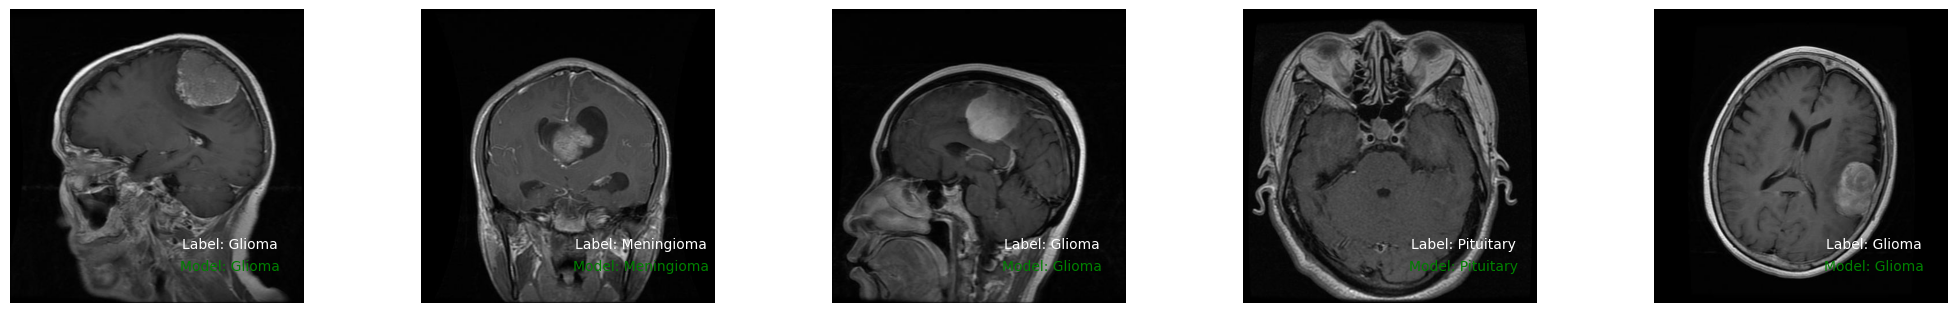

In [28]:
# This dictionary must fit the order of dataset labels
dict_disease = {
    0: "Meningioma",
    1: "Glioma",
    2: "No Tumor",
    3: "Pituitary"
}

def get_diagnosis(pred):
    val = np.max(pred)
    idx = np.where(pred == val)[0][0]
    return dict_disease[idx]

val_examples = list(val.unbatch().map(lambda x,y: x).batch(1))
val_answers = list(val.unbatch().map(lambda x,y: y))
sample_bag = list(zip(val_examples,val_answers))

samples = random.sample(sample_bag, 5)

figure, axis = plt.subplots(1,5,figsize=(25,25))
plt.subplots_adjust(wspace=0.4,hspace=0.4)
for i, sample in enumerate(samples):
    # Predict output
    val_x = sample[0]
    val_y = sample[1]
    y_hat = pruned_model.predict(val_x,verbose=0)[0]
    # Get diagnosis labaels
    label = get_diagnosis(val_y)
    prediction = get_diagnosis(y_hat)
    correct = (label == prediction)
    # Display results
    axis[i].imshow(tf.squeeze(val_x))
    axis[i].text(0.75, 0.2, f'Label: {label}', horizontalalignment='center', verticalalignment='center', transform=axis[i].transAxes, color='w')
    axis[i].text(0.75, 0.125, f'Model: {prediction}', horizontalalignment='center', verticalalignment='center', transform=axis[i].transAxes, color=('g' if correct else 'r'))
    axis[i].axis('off')
plt.show()


# Resources
### Convolution and Pooling:
In order to apply convolution in your own projects, you'll want to know how it turns image input into other image output(s) using kernels. Check [this stackoverflow post](https://stackoverflow.com/questions/43805860/tensorflow-understanding-tensor-shapes-for-convolution) to learn more about what the dimensions of a convolution layer & kernel mean, and how you can use them to your benefit.

Here's two examples of [Convolution](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) and [Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) from tensorflow's documentation.

### Pruning: 
[Optimize Layers / Units of a Neural Network](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw); Particularly check the comments made by @doug and @hobs, which I've found very useful when learning about pruning.

[Pruning Example (on Kaggle)](https://www.kaggle.com/code/nitinsss/pruning-a-neural-network#6.-Weight-Pruning); I used my own method of implementing pruning, however I still believe this is a good example, it turned theory into practice.

[Pruning intuition](https://www.datature.io/blog/a-comprehensive-guide-to-neural-network-model-pruning); explains the intuition and effects of pruning accurately.

#### Keras:
Separate from applying the custom method, tensorflow also provides its own tools for pruning. You might want to check [this documentation](https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras) if you want to know how.